## Analyze Counterfactual Data

In [1]:
import os
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st

import xgboost
from xgboost import XGBClassifier

from sklearn.model_selection import (
    StratifiedKFold,
    RandomizedSearchCV,
    train_test_split,
)
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
    
from sklearn.linear_model import LinearRegression

In [2]:
def create_bar_plot(x_values, y_values, title="", xlabel="", ylabel="", figname="", color_idx=0):
    colors = ["#003f5c", "#bc5090", "#ffa600"]
    
    fig = plt.figure(figsize=(6,4))
    
    plt.barh(x_values, y_values,color=colors[color_idx])
    plt.title(title)
    plt.xlabel(xlabel, fontsize=12)
    #plt.xscale('log')
    plt.ylabel(ylabel, fontsize=12)    
    plt.tight_layout()
    plt.savefig(figname, dpi=300)

In [3]:
data_dir = '/home/dauenha0/murp1677/Cyclic_Dynamics/Code/ML_repo/programmable-catalysis/dev/data/clf-op-counterfactuals/'
cfs = os.path.join(data_dir, 'counterfactuals-neg-to-pos.csv')
perturbations = os.path.join(data_dir, 'counterfactual-perturbations-neg-to-pos.csv')
queries = os.path.join(data_dir, 'query-instances-neg-to-pos.csv')

# load counterfactuals
df_cfs = pd.read_csv(cfs)
df_perturbations = pd.read_csv(perturbations)
queries = pd.read_csv(queries)

In [12]:
# Given feature_min and feature_max values
feature_min = [0.2, 0.2, 0.2, 0.6, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.3]
feature_max = [0.9, 0.9, 0.9, 1.2, 1.2, 1.2, 1.8, 1.8, 1.5, 1.5, 0.8]

# Function to normalize the DataFrame
def normalize_perturbation_sets(df, feature_min, feature_max, new_min=0, new_max=1):
    for i, column in enumerate(df.columns):
        min_val = feature_min[i]
        max_val = feature_max[i]
        df[column] = new_min + (df[column] - min_val) * (new_max - new_min) / (max_val - min_val)
    return df

# Normalize the DataFrame
pertubation_sets = df_perturbations

normalized_perturbation_sets = normalize_perturbation_sets(perturbation_sets.copy(), feature_min, feature_max)
print(normalized_perturbation_sets)


          alpha-a   alpha-b   alpha-c    beta-a    beta-b    beta-c  \
0   -2.857143e-01 -0.285714 -0.285714 -0.541667 -0.555556 -0.763889   
1   -2.142857e-01 -0.285714 -0.285714 -1.000000 -0.597222 -0.777778   
2   -2.857143e-01 -0.285714 -0.285714 -0.851852 -0.527778 -0.944444   
3   -7.936508e-02 -0.285714 -0.142857 -0.972222 -1.000000 -0.629630   
4   -7.142857e-02  0.126984 -0.285714 -0.870370 -0.944444 -1.000000   
..            ...       ...       ...       ...       ...       ...   
245 -2.142857e-01 -0.285714 -0.285714 -0.972222 -0.944444 -0.574074   
246 -2.857143e-01 -0.285714 -0.214286 -0.972222 -0.972222 -0.972222   
247 -1.586033e-16 -0.285714 -0.071429 -1.000000 -0.944444 -1.000000   
248 -2.857143e-01 -0.174603 -0.214286 -0.888889 -1.000000 -0.537037   
249 -2.142857e-01 -0.214286 -0.142857 -1.000000 -0.537037 -0.574074   

     gamma-b-a  gamma-c-a  delta-b-a  delta-c-a  change-in-bea  
0    -0.287037  -0.315476  -0.500000      -0.32      -0.250000  
1    -0.321429  -

In [11]:
feature_names = df_perturbations.mean().index.tolist()
# mean_values = df_perturbations.mean().tolist()
perturbation_sets = df_perturbations
print(perturbation_sets)

normalized_sets = normalize_multiple_perturbations(perturbation_sets, feature_min, feature_max)
print(normalized_sets)

#create_bar_plot(feature_names, mean_values, title=None, ylabel="Feature", 
#               xlabel="Mean Perturbation to Feature", figname="clf-op-mean-perturbations-neg-to-pos.tiff", color_idx=2)

      alpha-a   alpha-b  alpha-c    beta-a    beta-b    beta-c  gamma-b-a  \
0    0.000000  0.000000     0.00  0.275000  0.266667  0.141667   0.255556   
1    0.050000  0.000000     0.00  0.000000  0.241667  0.133333   0.214286   
2    0.000000  0.000000     0.00  0.088889  0.283333  0.033333   0.157143   
3    0.144444  0.000000     0.10  0.016667  0.000000  0.222222   0.000000   
4    0.150000  0.288889     0.00  0.077778  0.033333  0.000000   0.194444   
..        ...       ...      ...       ...       ...       ...        ...   
245  0.050000  0.000000     0.00  0.016667  0.033333  0.255556   0.057143   
246  0.000000  0.000000     0.05  0.016667  0.016667  0.016667   0.328571   
247  0.200000  0.000000     0.15  0.000000  0.033333  0.000000   0.057143   
248  0.000000  0.077778     0.05  0.066667  0.000000  0.277778   0.000000   
249  0.050000  0.050000     0.10  0.000000  0.277778  0.255556   0.644444   

     gamma-c-a  delta-b-a  delta-c-a  change-in-bea  
0     0.221429   0.00

TypeError: unsupported operand type(s) for -: 'str' and 'list'

In [14]:
# Dictionary to store the count of changes for each feature across all queries
feature_changes = {}

# Iterate through each query
for i in range(len(queries)):
    # Extract the original query and counterfactuals as dictionaries
    original_query = queries[i:i+1].to_dict('records')[0]
    counterfactuals = df_cfs[i*10:i*10+10].to_dict('records')
    
    # Initialize feature_changes for the current query
    if i not in feature_changes:
        feature_changes[i] = {feature: 0 for feature in original_query}
    
    # Iterate through each counterfactual
    for counterfactual in counterfactuals:
        # Compare each feature in the original query with the corresponding feature in the counterfactual
        for feature, value in original_query.items():
            if counterfactual[feature] != value:
                # If the feature value is different in the counterfactual, increment the change count for that feature
                feature_changes[i][feature] += 1


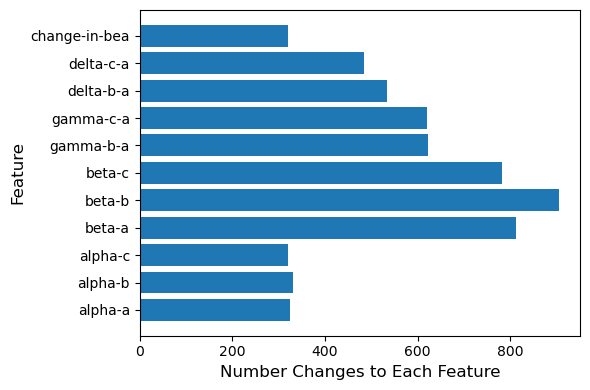

In [15]:
# Sum up all the changes for each feature across all queries
total_changes = {feature: sum(changes[feature] for changes in feature_changes.values()) for feature in feature_changes[0]}

feature_names = list(total_changes.keys())
num_changes = list(total_changes.values())

create_bar_plot(feature_names, num_changes, title="", xlabel="Number Changes to Each Feature", 
                ylabel="Feature", figname="clf-op-num-changes-zero-to-pos.tiff")

In [27]:
# Sum up all the changes for each feature across all queries
total_changes = {feature: sum(changes[feature] for changes in feature_changes.values()) for feature in feature_changes[0]}

# Print the total count of changes for each feature across all queries
for feature, count in total_changes.items():
    print(f"Total changes for feature '{feature}': {count}")

Total changes for feature 'alpha-a': 324
Total changes for feature 'alpha-b': 330
Total changes for feature 'alpha-c': 321
Total changes for feature 'beta-a': 813
Total changes for feature 'beta-b': 905
Total changes for feature 'beta-c': 781
Total changes for feature 'gamma-b-a': 622
Total changes for feature 'gamma-c-a': 621
Total changes for feature 'delta-b-a': 533
Total changes for feature 'delta-c-a': 484
Total changes for feature 'change-in-bea': 319
